# Trellis: Hierarchical Tree-Based Single-Cell Treatment Effect Analysis

Here we demonstrate Trellis, a tool for hierarchical classification of single-cell samples that enables the fast and efficient calculaion of distances across thousands of distributions containing single-cell information. This is an interactive notebook, that can be run and edited to understand step by step the functionalities of Trellis and its derivates.  

Trellis consists of the following steps:

* [Load and pre-process the data.](#step-zero)
* [1. Design a layer of "Fixed Branches" with a subset of markers based on prior knowledge and define +/- thresholds to classify the cells.](#step-one)
* [2. Define a -leaf runner- function that performs k-means hierarchical clustering on the subtrees from 1, calculating the "Random Leaves".](#step-two)
* [3. Alternatively, if we don't want to a defined fixed layer but instead we want to weight all markers equally: define a -tree runner- function that performs k-means hierarchical clustering on the dataset (skipping step 1). This is refered to as TreEMD.](#step-three)
* [4. Calculate parallel differential abundance between variables and internal conotrols (This is called -pairing- and it is also an optional step.](#step-four)
* [5. Use PHATE to visualise the resulting abundance matrices from 2, 3 or 4.](#step-five)


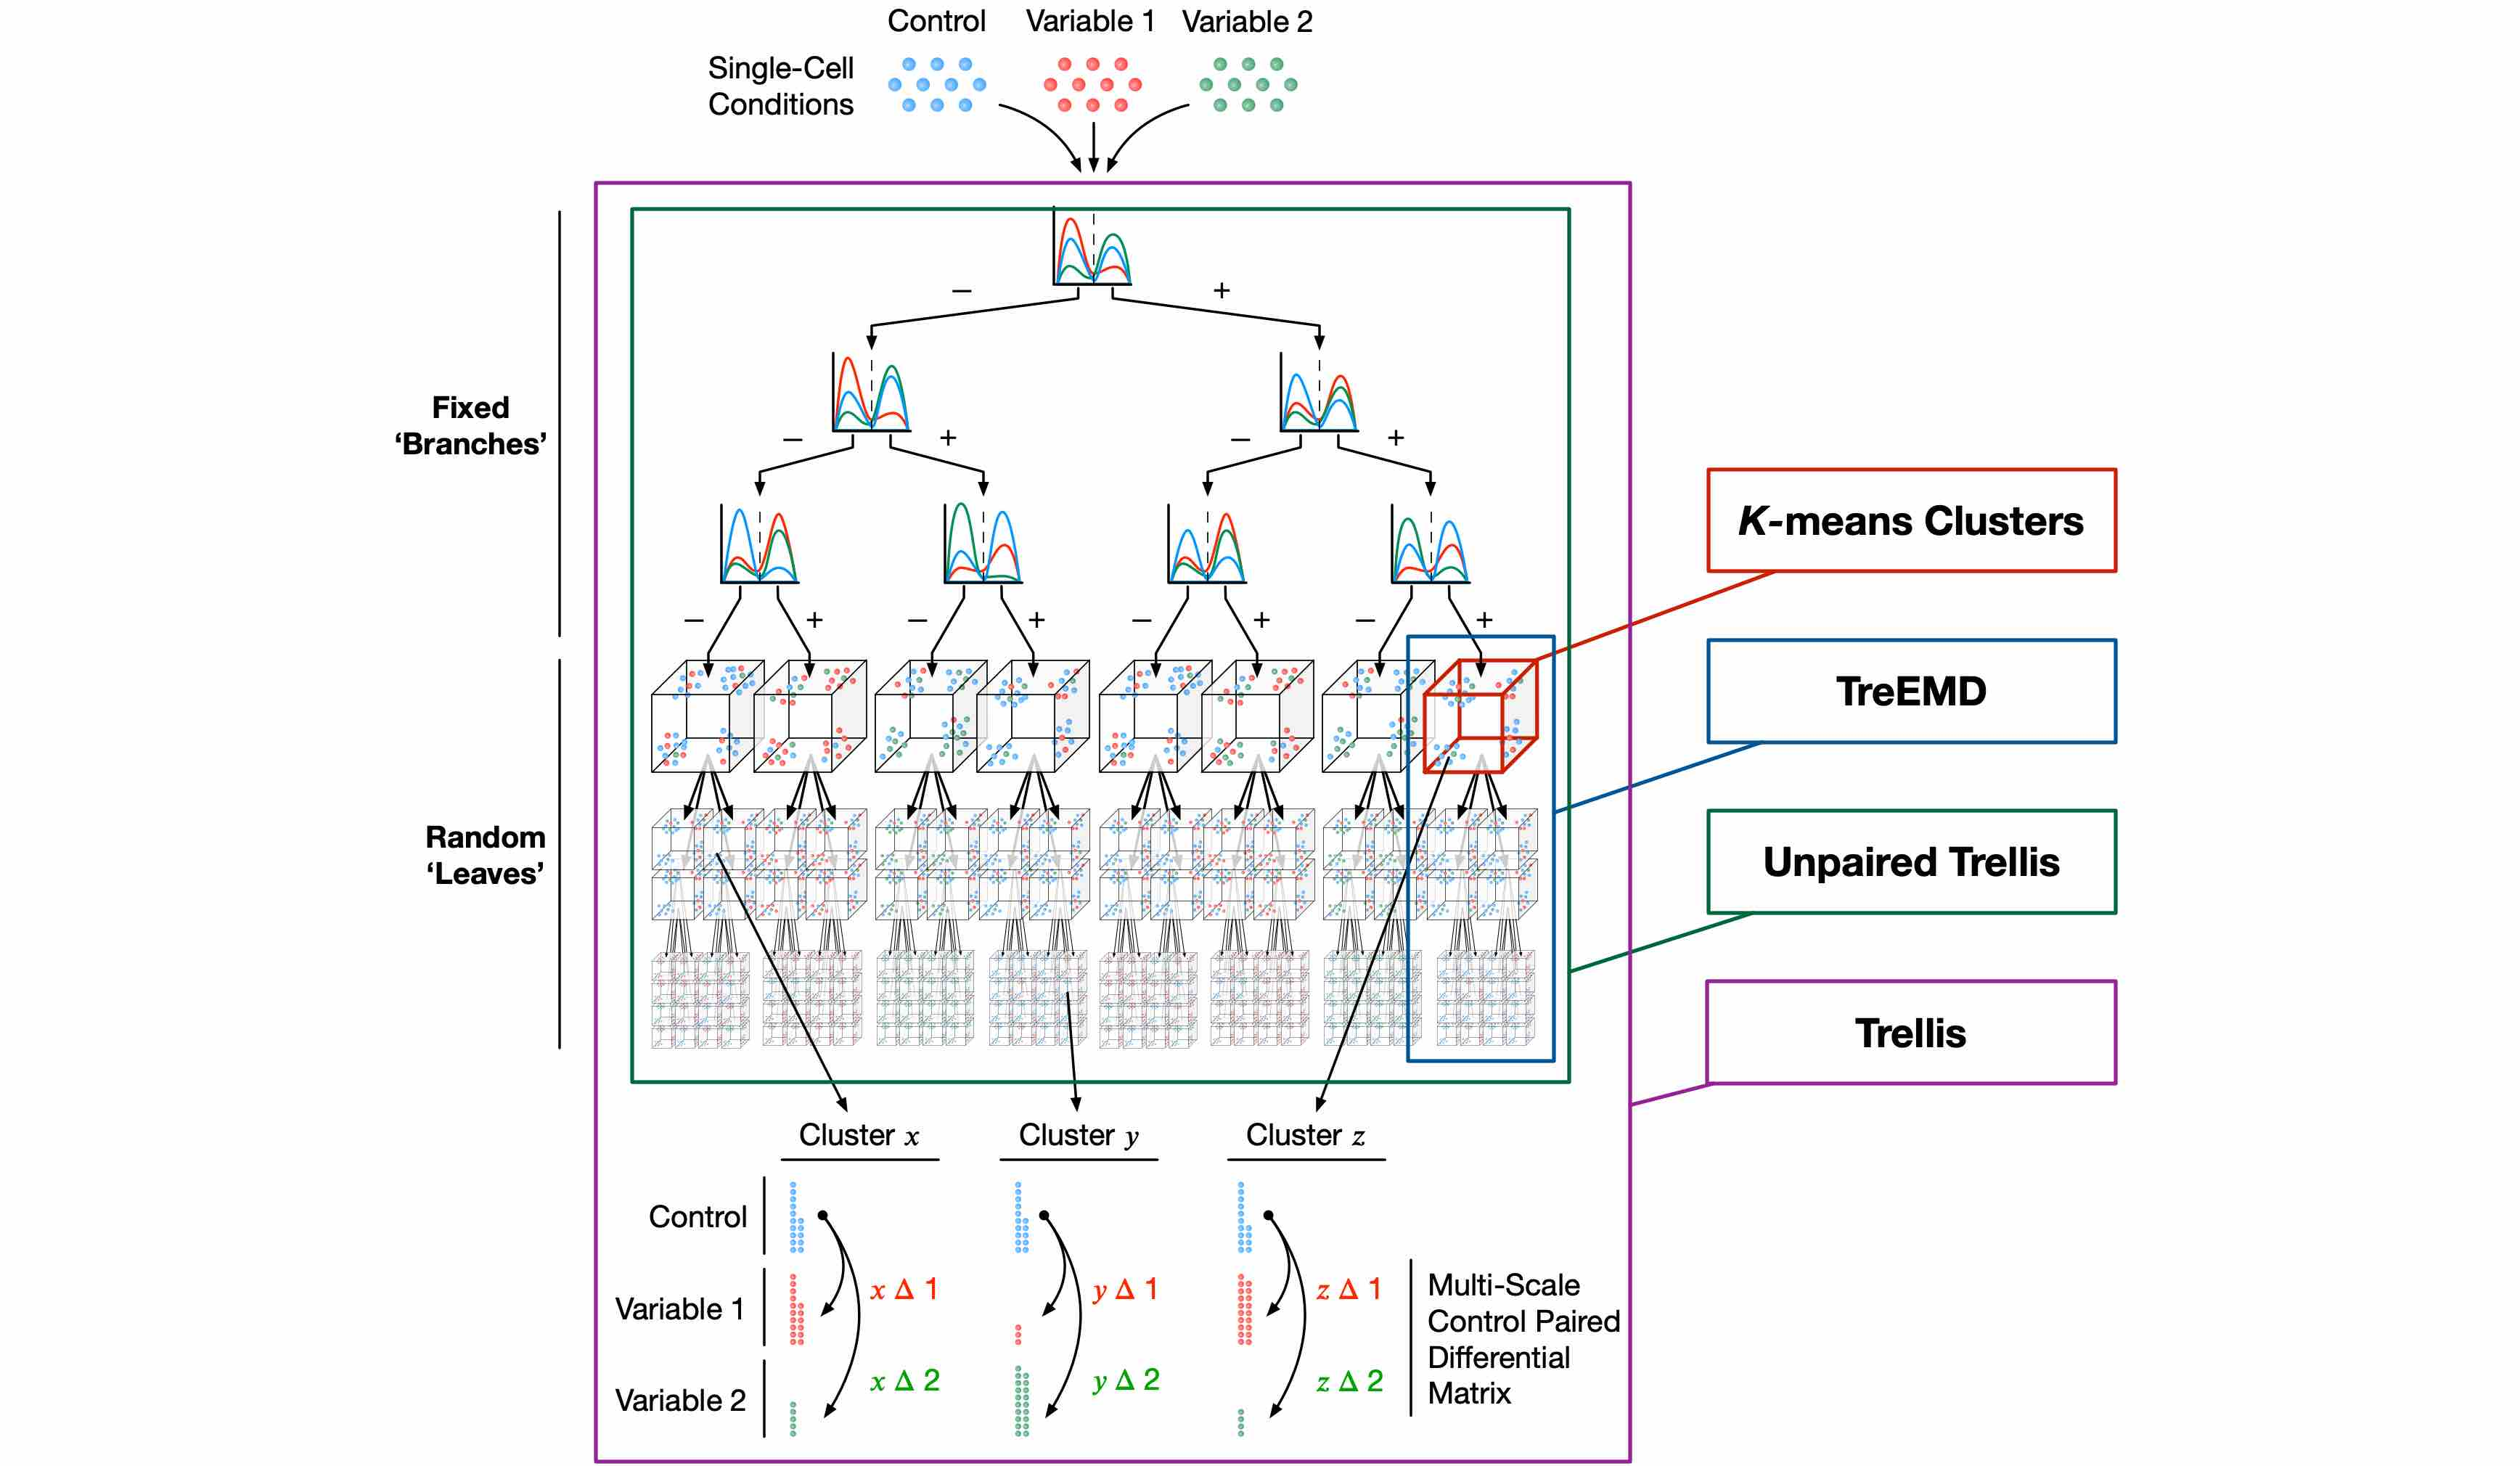

The maleability of Trellis enables the use of the different layers independently from each other depending on the experimental design and research question. This way, by adding or removing fixed branches and paired comparisons, we can analyse a dataset using Paired or Unpaired TreEMD and Trellis:

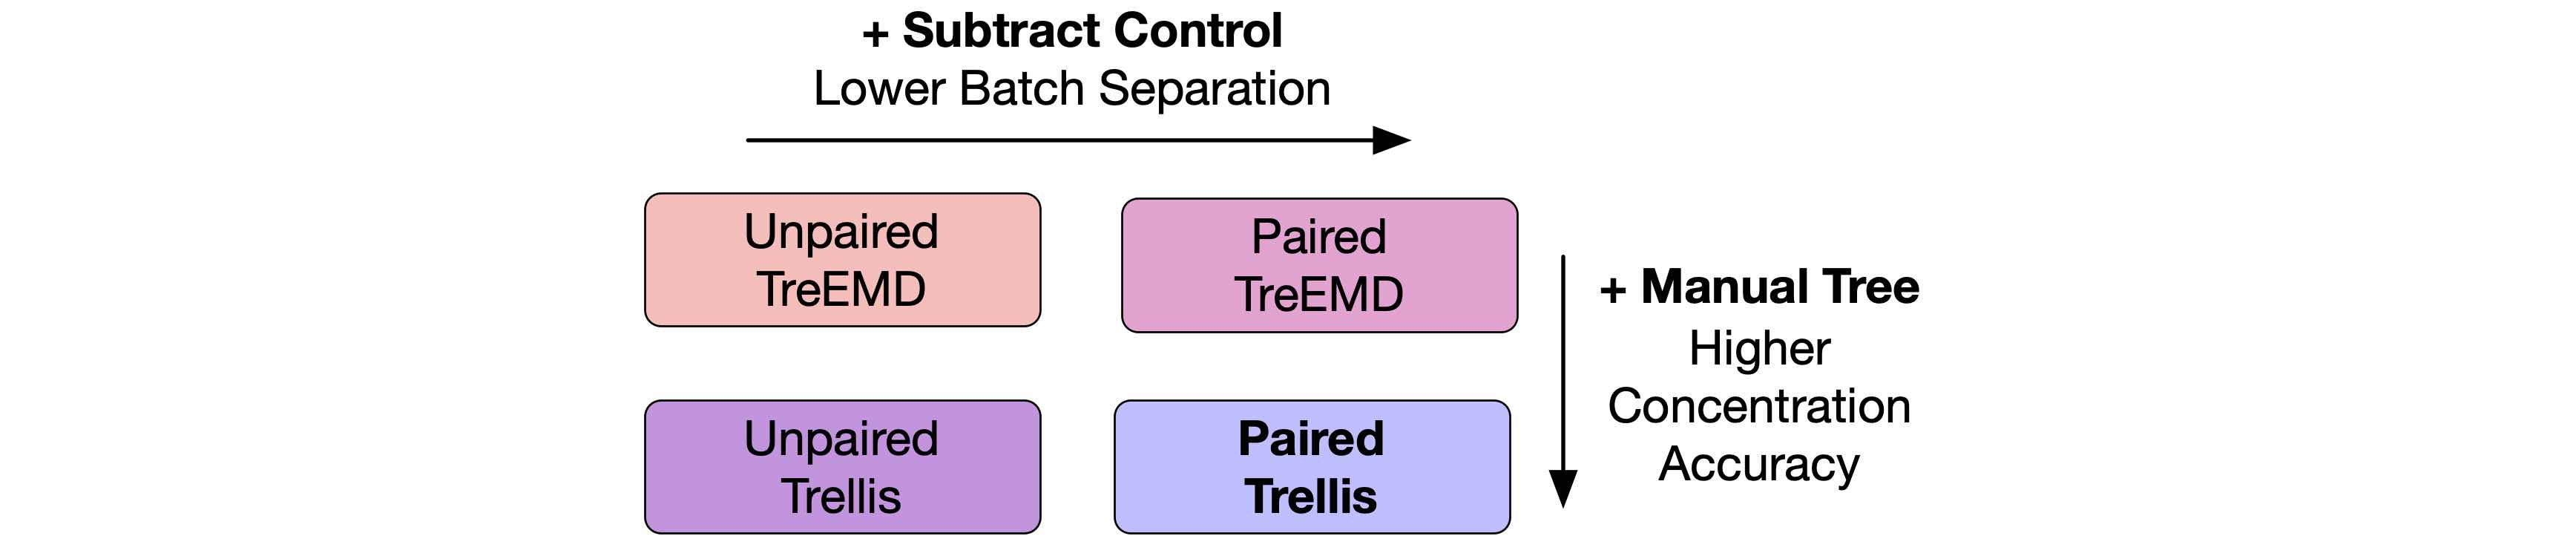


But first things first, let's install all the packages needed and import them:

In [1]:
#Install packages 
!pip install phate
!pip install MultiscaleEMD
!pip install scprep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.9/664.9 kB 3.2 MB/s eta 0:00:00


In [2]:
#Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder
import phate
import scprep
from MultiscaleEMD import MetricTree


<a id="step-zero"></a>

# Load and pre-process the data
The data set that we will be using is a subset of a larger dataset developped in our pre-print: 'Trellis Single-Cell Screening Reveals Stromal Regulation of Patient-Derived Organoid Drug Responses' (https://www.biorxiv.org/content/10.1101/2022.10.19.512668v2). This dataset was created with Colorectal Cancer (CRC) Patient-Derived Organoids (PDOs) that were treated with a range of chemotherapies and targeted therapies at ranges of concentrations. PDOs were treated alone, but also in 3D co-cultures with CRC Cancer-Associated Fibroblasts (CAFs) to understand the influence of this cell type in the responses to therapies of PDOs from different CRC patients.

In the pre-print, we present the data corresponding to PDOs from 10 different patients. For this demonstration, we use a subset of the data, using only one patient (PDO 21) and we will compare different treatments and culture conditions on these cells using Trellis.

The dataframe is formed of rows that correspond to each cell, and columns that include raw intensities of each marker measured by CyTOF as well as 9 columns corresponding to metadata information, including: 

* Date of acquisition.
* Patient, in this case we only have 21.
* Culture, if the cells were cultured in monoculture - PDO, or co-culture - PDOF.
* Treatment, drug added to the culture: SN-38 (S), 5-FU (F), Oxaliplatin (O), LGK974 (L), Cetuximab (C), Berzosertib - VX970 (V), or SF, CS, CSF, CF, SV when either of these treatments were used in combination. Vehicle controls (used depending on the vehicle of each treatment) are named as: DMSO, AH (ammounium hydroxide) or H2O (water).
* Concentration, ranging on string values from 0 (Controls) to 5 (highest concentration or combination). Specific concentrations are detailed on Table S2 on the pre-print.
* Replicate, A, B and C. AA, BB and CC are extra replicates used only in control conditions. 
* Cell type: specific cell type of that cell, being either cancer cells (PDO) or CAFs (F). This dataset only contains information from the cancer cells.
* Plate: Because samples were acquired separately, internal controls were included in each well plate. The labels of the plates are either SLV, CSF or O. These will be used to find internal controls.
* Batch: Because of the size of the experiment, some samples were acquired at the beggining of the year (Batch 1) and some were acquired at the end of the year (Batch 2). This column can be ignored since Dates and Plates will be used for batch correction purposes instead. 

In [3]:
#Load dataframe containing PDO 21 data
raw_df = pd.read_csv("/kaggle/input/trellis-pdo21-pdo-caf-screen/Metadata_PDO21")
raw_df.head()

,Unnamed: 0,pHH3,RFP,mCHERRY,Vimentin,EpCAM,CK18,Pan_CK,GFP,IdU,...,Date,Patient,Culture,Treatment,Concentration,Replicate,Cell_type,pPKCa,Plate,Batch
0,3426741,0.0,66.629486,364.683258,6.857351,100.333038,353.976471,1270.591309,17.422998,0.000000,...,20210413,21,PDO,S,1,A,PDOs,NaN,SLV,1
1,3426742,0.0,10.939805,126.974174,6.878655,27.369486,98.313110,526.727112,0.000000,0.086549,...,20210413,21,PDO,S,1,A,PDOs,NaN,SLV,1
2,3426743,0.0,31.755527,157.037338,0.037283,19.240530,36.997742,309.435638,0.000000,0.000000,...,20210413,21,PDO,S,1,A,PDOs,NaN,SLV,1
3,3426744,0.0,46.551430,203.116074,0.279620,58.424633,270.611053,678.357117,2.142423,0.000000,...,20210413,21,PDO,S,1,A,PDOs,NaN,SLV,1
4,3426745,0.0,10.885213,74.433548,0.000000,18.307131,44.491558,172.839874,0.000000,0.000000,...,20210413,21,PDO,S,1,A,PDOs,NaN,SLV,1


Once we have loaded the packages and the dataset, the first step is to pre-process the data for its analysis.
* We are removing 'pPKCa' from the analysis because this marker was not available across the whole dataset, and it created NaN values in some subsets of the data. 'Unnamed: 0' will also be removed since it's the cell index from the full dataset.
* Optional: when working with large samples, for example if we were working with the whole dataset, we may want to downsample to lower numbers.
* Creating a tag to normalise the samples by batches 
* Arcsinh normalisation of raw values
* Mean centering the intensities by batch


In [4]:
#Clean-up: removing 'pPKCa' to remove NaN values and 'Unnamed: 0'

raw_df.drop(['pPKCa', 'Unnamed: 0'], axis=1, inplace=True)
# raw_df = raw_df.sample(n=100000, random_state=1, replace=False)
raw_df.index = np.arange (raw_df.shape[0])

#Creates a column for normalization ("Norm_tag") that includes Patient + Date information
def col_join(arr):
    """ Joins columns of a dataframe into a single column with underscores """
    return "_".join(np.array(arr).astype("str"))
    
norm_tags = raw_df.iloc[:, -9:-7].T.apply(col_join).rename("Norm_tag")
df_with_tags = pd.concat([raw_df, norm_tags], axis=1)

#We need to split the data to normalise the numerical columns
data_for_norm = df_with_tags.iloc[:, :-10]
non_numerical = df_with_tags.iloc[:, -10:-1]

# Arcsinh transformation and batch normalisation on raw data by "Norm_tag"
data_arcs = np.arcsinh(data_for_norm / 5)
data_centered = scprep.normalize.batch_mean_center(
    data_arcs.copy(), sample_idx=df_with_tags["Norm_tag"]
)

#Re-merge the non-numerical values to the normalised data
full_centered = pd.concat([data_centered, non_numerical], axis=1)

To avoid issues in future steps, we will create a unique tag for every sample, including the complete information from the metadata. We will use this column to order the dataframes by it, avoiding mix-ups. 

In [5]:
# Build a canonical list of names for each sample so we can order by this in
# all subsequent processing

full_names = full_centered.iloc[:, -9:].T.apply(col_join).rename("Full_name")
df_with_names = pd.concat([full_centered, full_names], axis=1)

metadata = df_with_names.iloc[:, -10:]
data = full_centered.iloc[:, :-9]



Now that we have pre-processed and normalized the data, we are ready to start. The dataframe "Full_data" will be the dataset ready for its analysis with Trellis, it contains the metadata information of each sample as well as itsunique tag,and the arcsinh-transformed and batch-normalized intensities for each of the markers measured.

In [6]:
full_data = pd.concat([metadata, data], axis=1)
full_data

,Date,Patient,Culture,Treatment,Concentration,Replicate,Cell_type,Plate,Batch,Full_name,...,pERK1_2,pSMAD2_3,PLK,CHGA,pDNAPK,pS6,CD90,cPARP,pCHK1,Cyclin_B1
0,20210413,21,PDO,S,1,A,PDOs,SLV,1,20210413_21_PDO_S_1_A_PDOs_SLV_1,...,0.340376,-1.542426,0.700479,0.938442,0.240513,0.501589,-1.372296,-1.072640,0.247818,-0.520391
1,20210413,21,PDO,S,1,A,PDOs,SLV,1,20210413_21_PDO_S_1_A_PDOs_SLV_1,...,-1.231748,-1.542426,0.502331,-0.165882,0.676408,-0.735821,1.764565,-1.125128,1.058647,-2.045097
2,20210413,21,PDO,S,1,A,PDOs,SLV,1,20210413_21_PDO_S_1_A_PDOs_SLV_1,...,-0.184958,0.640187,-0.505754,-0.165882,0.033417,-0.735821,-1.372296,-2.728045,-1.265797,-2.045097
3,20210413,21,PDO,S,1,A,PDOs,SLV,1,20210413_21_PDO_S_1_A_PDOs_SLV_1,...,0.110054,-1.542426,-2.281331,-0.165882,-0.151865,-0.735821,1.825443,0.439057,1.530180,-1.536048
4,20210413,21,PDO,S,1,A,PDOs,SLV,1,20210413_21_PDO_S_1_A_PDOs_SLV_1,...,-1.231748,-0.269559,-3.026473,2.004175,0.818126,-0.735821,0.801796,-0.294029,0.300360,-2.045097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619661,20220328,21,PDOF,H2O,0,B,PDOs,O,2,20220328_21_PDOF_H2O_0_B_PDOs_O_2,...,-0.320688,-0.276594,0.734821,-0.260084,-0.039578,0.284098,0.167016,0.195823,0.376713,-0.652822
619662,20220328,21,PDOF,H2O,0,B,PDOs,O,2,20220328_21_PDOF_H2O_0_B_PDOs_O_2,...,-0.883529,-0.850224,-0.734848,-0.260084,-1.150183,-0.234617,-0.339299,0.049680,-1.287677,-0.652822
619663,20220328,21,PDOF,H2O,0,B,PDOs,O,2,20220328_21_PDOF_H2O_0_B_PDOs_O_2,...,0.057285,-0.850224,0.783411,-0.260084,-1.150183,-0.234617,-0.339299,0.864742,-1.287677,-0.652822
619664,20220328,21,PDOF,H2O,0,B,PDOs,O,2,20220328_21_PDOF_H2O_0_B_PDOs_O_2,...,-0.271821,-0.850224,-0.734848,-0.260084,-0.849005,-0.234617,-0.089895,2.790117,0.333257,-0.652822


Finally, we need to create a list of samples, not single cells anymore, containing the metadata information grouped by sample, and the mean intensity of each marker:

In [7]:
#Group rows by sample and calculate the mean intensity of each column.
mean_locs = (
    df_with_names.groupby(
        [
            "Culture",
            "Date",
            "Treatment",
            "Concentration",
            "Replicate",
            "Cell_type",
            "Patient",
            "Full_name",
            "Batch", 
            "Plate"
        ]
    )
    .mean()
)

meta = mean_locs.index.to_frame()

# Sorting is necessary so that np.unique works for labeling the samples on the tree
# meta contains one line per sample and the metadata table associated with that sample
meta = meta.reset_index(drop=True).sort_values("Full_name").reset_index(drop=True)
meta

,Culture,Date,Treatment,Concentration,Replicate,Cell_type,Patient,Full_name,Batch,Plate
0,PDOF,20210413,AH,0,A,PDOs,21,20210413_21_PDOF_AH_0_A_PDOs_CSF_1,1,CSF
1,PDOF,20210413,AH,0,B,PDOs,21,20210413_21_PDOF_AH_0_B_PDOs_CSF_1,1,CSF
2,PDOF,20210413,AH,0,C,PDOs,21,20210413_21_PDOF_AH_0_C_PDOs_CSF_1,1,CSF
3,PDOF,20210413,CF,3,A,PDOs,21,20210413_21_PDOF_CF_3_A_PDOs_CSF_1,1,CSF
4,PDOF,20210413,CF,3,B,PDOs,21,20210413_21_PDOF_CF_3_B_PDOs_CSF_1,1,CSF
...,...,...,...,...,...,...,...,...,...,...
163,PDO,20220328,O,2,B,PDOs,21,20220328_21_PDO_O_2_B_PDOs_O_2,2,O
164,PDO,20220328,O,2,C,PDOs,21,20220328_21_PDO_O_2_C_PDOs_O_2,2,O
165,PDO,20220328,O,3,A,PDOs,21,20220328_21_PDO_O_3_A_PDOs_O_2,2,O
166,PDO,20220328,O,3,B,PDOs,21,20220328_21_PDO_O_3_B_PDOs_O_2,2,O


When running trees, we will sometimes choose to use only signalling markers for the random leaves if we have designed fixed branches (**Trellis**) -- data_sig, or we will use both signalling and cell state markers for the random leaves (**TreEMD**) -- data_all.

In [8]:
#Remove cell_type markers or problematic antibodies (cCaspase_3) and cell-state markers, keeping only signalling markers
non_sig_markers = [
    "pHH3", "RFP", "mCHERRY", "Vimentin", "EpCAM", "CK18", "Pan_CK", "GFP", "IdU", "cCaspase_3", "Geminin", "pRB", "PLK", "CHGA", "CD90", "cPARP", "Cyclin_B1",
]

#Dataframe containing only signalling markers
data_sig = data.drop(
    non_sig_markers,
    axis=1,
    inplace=False,
)

#Remove cell_type markers or problematic antibodies (cCaspase_3)
cell_type_markers = [
    "RFP", "mCHERRY", "Vimentin", "EpCAM", "CK18", "Pan_CK", "GFP", "CHGA", "CD90", "cCaspase_3"
]

#Dataframe containing cell-state and signalling markers
data_all = data.drop(
    cell_type_markers,
    axis=1,
    inplace=False,
)

All right, we're all set now to start using Trellis on our data!

<a id="step-one"></a>
# 1. Design a layer of "Fixed Branches"

In this step, we are going to distribute the cells through "subtrees" that will correspond to each cell state that we want to gate for. As described in the pre-print, for this dataset we are interested in weighting for the different cell states that include cell cycle phases as well as non proliferative states (Apoptosis, G0, G1, S, G2 and M phases). Within each of these groups, we also want to classify the cells by their status in terms of DNA damage response (pHH2AX activation). The fixed branches described down below correspond to the following structure:

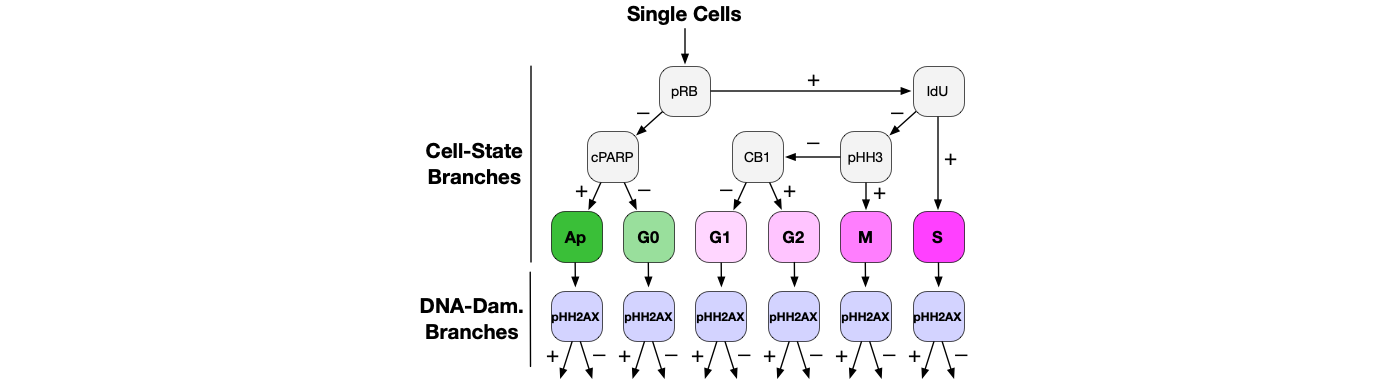

As a result, we will be gating for 12 different subtrees that will correspond to each cell-state +/- pHH2AX activation. The thresholds to gate for each marker are designed manually based on prior knowledge to distinguish between negative and possitive intensities.

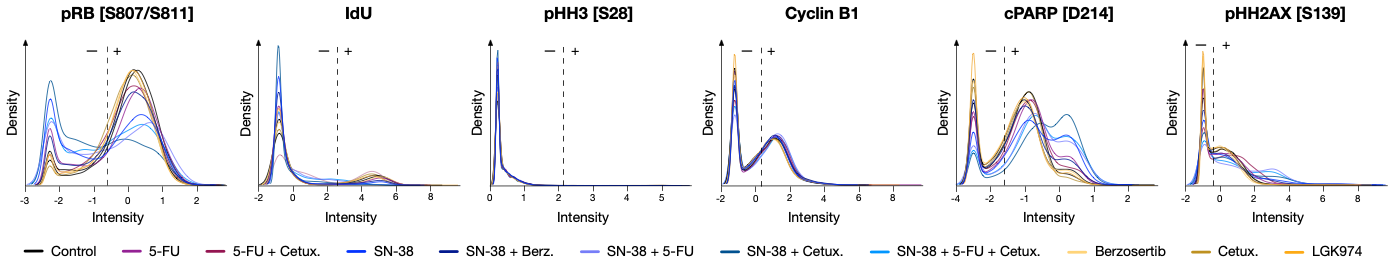

Due to technical difficulties, the data corresponding to treatments Oxaliplatin (O) and H2O were acquired in a separate batch. For this reason, the thresholds are set independently between batches, thanks to the "Norm_tag" column created previously.

In [9]:
# Build a subtree for each leaf phase
unique, inverse = np.unique(full_names, return_inverse=True)
assert np.array_equal(unique, meta["Full_name"].values)

#Set a threshold, if needed, set different thresholds for each batch ("Norm_tag").
thresholds = {
    "20220328_21": {
        "pRB": 0.5,
        "IdU": 2,
        "pHH3": 3,
        "Cyclin_B1": 0,
        "cPARP": -0.9,
        "pHistone_H2A":-0.2
    },
    "20210413_21": {
        "pRB": -0.5,
        "IdU": 2,
        "pHH3": 3,
        "Cyclin_B1": -1,
        "cPARP": -0.5,
        "pHistone_H2A":-0.6
    },
}

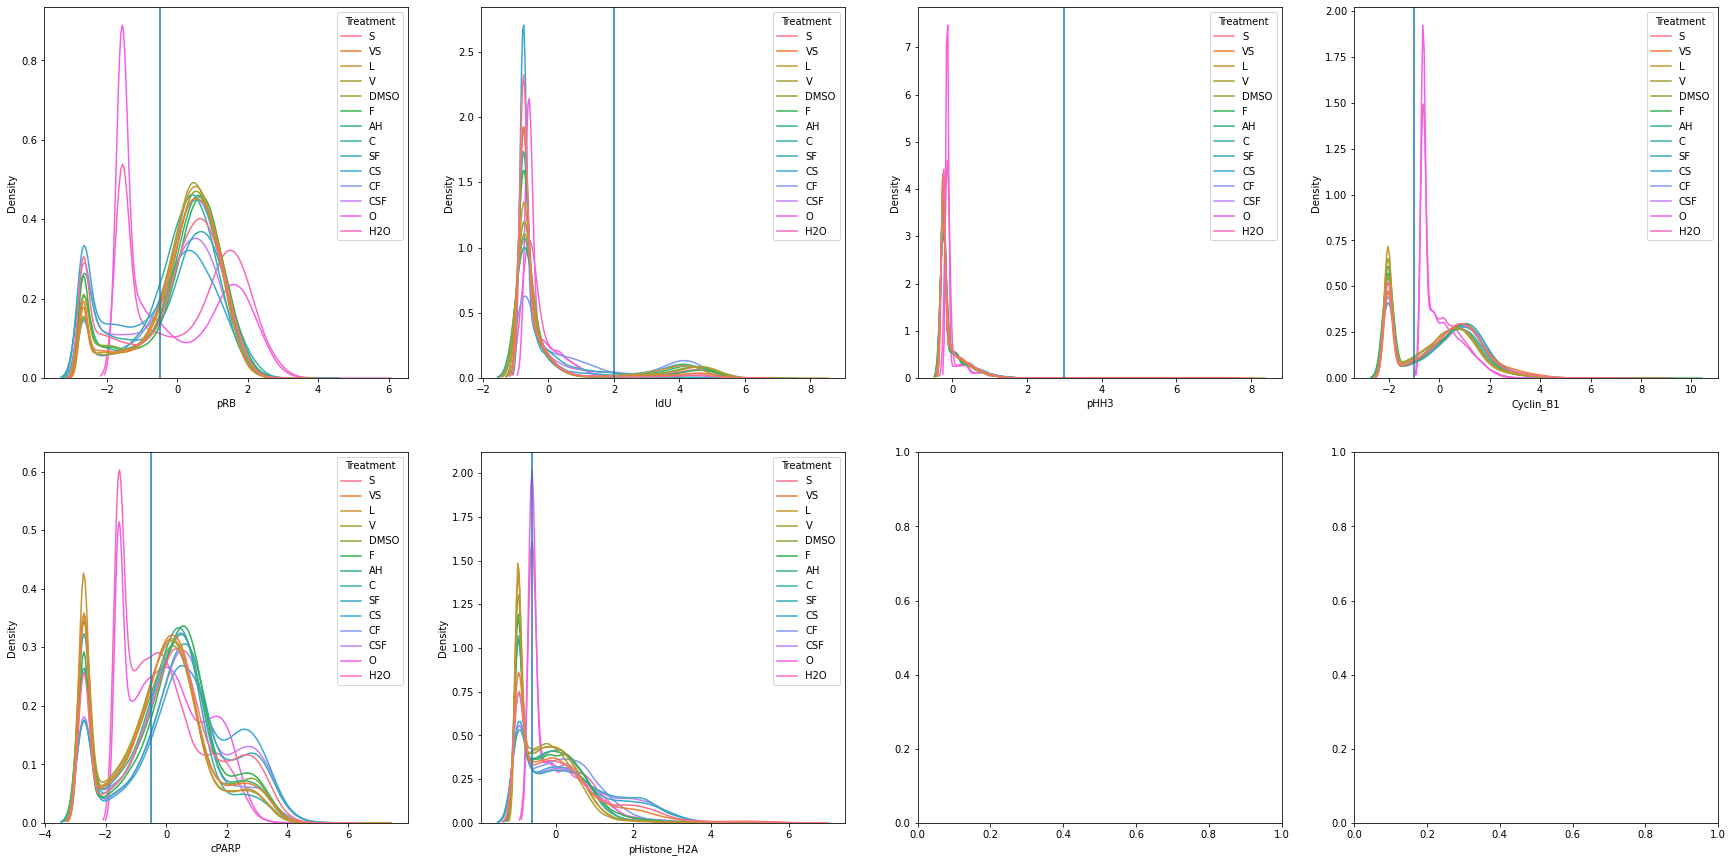

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()
for i, (gene, thresh) in enumerate(thresholds['20210413_21'].items()):
    ax = axes[i]
    sns.kdeplot(data=data_centered, hue=full_data['Treatment'], x=gene, common_norm=False, ax=ax)
    ax.axvline(thresh)

In [11]:
#Design conditional gating using the thresholds described

discretes = []
for norm_tag in df_with_tags["Norm_tag"].unique():
    mask = df_with_tags["Norm_tag"] == norm_tag
    discretes.append(
        pd.concat(
            [data_centered[mask][gene] > thresh for gene, thresh in thresholds[norm_tag].items()],
            axis=1,
        )
    )
discrete = pd.concat(discretes, axis=0).reindex(data.index)
tree = {
    "S_phase_H2Ahi": discrete["pRB"] & discrete["IdU"] & discrete["pHistone_H2A"],
    "S_phase_H2Alo": discrete["pRB"] & discrete["IdU"] & ~discrete["pHistone_H2A"],
    "M_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & discrete["pHH3"]
     & discrete["pHistone_H2A"],
    "M_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & discrete["pHH3"]
     & ~discrete["pHistone_H2A"],
    "G2_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & discrete["Cyclin_B1"] & discrete["pHistone_H2A"],
    "G2_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & discrete["Cyclin_B1"] & ~discrete["pHistone_H2A"],
    "G1_phase_H2Ahi": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & ~discrete["Cyclin_B1"] & discrete["pHistone_H2A"],
    "G1_phase_H2Alo": discrete["pRB"] & ~discrete["IdU"] & ~discrete["pHH3"]
    & ~discrete["Cyclin_B1"] & ~discrete["pHistone_H2A"],
     "Apoptosis_H2Ahi": ~discrete["pRB"] & discrete["cPARP"] 
    & discrete["pHistone_H2A"],
    "Apoptosis_H2Alo": ~discrete["pRB"] & discrete["cPARP"] 
    & ~discrete["pHistone_H2A"],
    "G0_phase_H2Ahi": ~discrete["pRB"] & ~discrete["cPARP"] 
    & discrete["pHistone_H2A"],
    "G0_phase_H2Alo": ~discrete["pRB"] & ~discrete["cPARP"] 
    & ~discrete["pHistone_H2A"],
}

#Create a df containing the subtrees as columns and cells as rows

df_tree = pd.DataFrame(tree)
leaf_phases = ["S_phase_H2Ahi", "S_phase_H2Alo", "M_phase_H2Ahi", "M_phase_H2Alo",
"G2_phase_H2Ahi", "G2_phase_H2Alo", "G1_phase_H2Ahi", "G1_phase_H2Alo", "Apoptosis_H2Ahi", "Apoptosis_H2Alo", "G0_phase_H2Ahi", "G0_phase_H2Alo"
]

In [12]:
df_tree.head()

,S_phase_H2Ahi,S_phase_H2Alo,M_phase_H2Ahi,M_phase_H2Alo,G2_phase_H2Ahi,G2_phase_H2Alo,G1_phase_H2Ahi,G1_phase_H2Alo,Apoptosis_H2Ahi,Apoptosis_H2Alo,G0_phase_H2Ahi,G0_phase_H2Alo
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False


Another use of the "df_tree" dataframe is creating a simple matrix that contains the proportions of cells within each subtree (or cell-state) per sample:

In [13]:
proportions = (
    pd.concat([metadata, df_tree], axis=1)
    .groupby(
        [
            "Culture",
            "Date",
            "Treatment",
            "Concentration",
            "Replicate",
            "Cell_type",
            "Patient",
            "Full_name",
            "Batch"
        ]
    )
    .mean()
    .sort_values("Full_name")
    .reset_index(drop=True)
)
proportions.head()

,S_phase_H2Ahi,S_phase_H2Alo,M_phase_H2Ahi,M_phase_H2Alo,G2_phase_H2Ahi,G2_phase_H2Alo,G1_phase_H2Ahi,G1_phase_H2Alo,Apoptosis_H2Ahi,Apoptosis_H2Alo,G0_phase_H2Ahi,G0_phase_H2Alo
0,0.026569,0.005039,0.002290,0.000000,0.231333,0.103069,0.064590,0.052680,0.245076,0.171324,0.034356,0.063674
1,0.073555,0.014886,0.003940,0.000876,0.422942,0.150613,0.101576,0.052977,0.071366,0.045534,0.021454,0.040280
2,0.063993,0.011377,0.002560,0.000284,0.261092,0.125142,0.083902,0.060011,0.205347,0.127986,0.025028,0.033276
3,0.063230,0.013402,0.003780,0.000687,0.422680,0.138488,0.097595,0.057388,0.079038,0.056701,0.030928,0.036082
4,0.081608,0.013398,0.001624,0.000000,0.410475,0.150223,0.100690,0.056841,0.079578,0.045879,0.019894,0.039789


<a id="step-two"></a>
# 2. Define Trellis "Random Leaves"

Now that we have designed the "Fixed Branches" and we have a df_tree dataframe where we have classified the cells by subtrees, we are going to define a function called "leaf_runner" that will create the tree embeddings for each sample under each subtree. 

The first step to start working with the trees is to create a one hot matrix where we create unique labels for each sample, and normalised these lables to weight equally samples that have different cell numbers.

In [14]:
# Encodes a cell x sample one hot matrix where labels_ij = 1 if cell i is in sample j
onehot = OneHotEncoder(sparse=True)
labels = onehot.fit_transform(inverse.reshape(-1, 1))

# Constructs normalized (sparse) label matrix where normed_labels_ij = 1 / sum(# cells in sample j)
d = np.array(labels.sum(axis=0)).flatten()
labels_normed = labels.tocoo()
labels_normed.data = labels_normed.data / d[labels_normed.col]
labels_normed = labels_normed.tocsr()

The "leaf_runner" function will calculate the k-means clusters at several levels under each subtree defined in df_tree from the "Fixed branches". The function requires the following inputs:

* data: matrix containing # cells x # features
* labels: matrix containing # cells x # samples (this comes from a one hot matrix where labels_ij = 1 if cell i is in sample j)
* tree_type: defines the type of metric tree. In this case we will use "cluster".
* n_trees: how many trees to build, the output will be the result of the average of all reiterations. Higher number of trees will show higher accuracy at higher computational cost (time).
* norm_per_subtree: whether to treat each subtree as a separate distribution, this essentially weights each subtree equally, rather than weighting based on how many cells are in each subtree (default).

This function returns four objects:

* leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance between embeddings represents tree EMD.
* leaf_trees: tree objects for each tree.
* leaf_ids: Leaf label for each tree node [n_nodes] containing the strings of the leaf_phases.
* leaf_counts: number of cells in each leaf.

In [15]:
def l1_embeddings(cts, edge_weights):
    return np.array(
        [np.asarray(cts)[i, :] * np.asarray(edge_weights) for i in range(len(cts))]
    )


def leaf_runner(
    data, labels, tree_type, n_trees, norm_per_subtree=False, random_state=42, **kwargs
):
    leaf_embeds = []
    leaf_counts = []
    leaf_trees = []
    leaf_ids = []
    # note that we only build a tree for each leaf phase leaving out proliferating vs. not
    rs = random_state
    for leaf in leaf_phases:
        mask = np.array(df_tree[leaf])
        sub_data = data[mask]
        sub_labels = labels[mask]
        if norm_per_subtree:
            d = np.array(sub_labels.sum(axis=0)).flatten()
            # Fix divide by zero errors
            d = np.clip(d, a_min=1e-8, a_max=None)
            sub_labels = sub_labels.tocoo()
            sub_labels.data = sub_labels.data / (d[sub_labels.col])
            sub_labels = sub_labels.tocsr()
        embeds = []
        mts = []
        all_counts = []
        for i in range(n_trees):
            mt = MetricTree(tree_type=tree_type, dense=False, random_state=rs, **kwargs)
            counts, edge_weights = mt.fit_transform(
                X=sub_data,
                y=sub_labels,
            )
            all_counts.append(counts)
            embeds.extend(l1_embeddings(counts, edge_weights).T)
            mts.append(mt)
        embeds = np.array(embeds).T
        all_counts = np.concatenate(all_counts, axis=-1)
        leaf_embeds.append(embeds)
        leaf_counts.append(all_counts)
        leaf_trees.append(mts)
        leaf_ids.append([leaf] * embeds.shape[1])
        rs += 1
    leaf_embeds = np.concatenate(leaf_embeds, axis=1)
    leaf_counts = np.array(np.concatenate(leaf_counts, axis=1))
    leaf_ids = np.concatenate(leaf_ids)
    return leaf_embeds, leaf_trees, leaf_ids, leaf_counts




<a id="step-three"></a>
# 3. Optional: Define TreEMD "Random Leaves"

TreEMD is a variation of Trellis where we don't weight for any specific phenotype. In this case, we design a function called "tree_runner" where we do not use the defined thresholds but we are running one single tree with the whole datastet. While the input for this function is the same as the "leaf_runner" function, the output differs:

* leaf_embeds: [# distributions x (n_trees x n_nodes)] embeddings one per distribution where L1 distrance between embeddings represents tree EMD.
* mts: trees

In [16]:
def tree_runner(data, labels, tree_type, n_trees, random_state=42, **kwargs):
    embeds = []
    mts = []
    for i in range(n_trees):
        mt = MetricTree(tree_type=tree_type, random_state=random_state + i, **kwargs)
        counts, edge_weights = mt.fit_transform(
            X=data,
            y=labels,
        )
        embeds.extend(l1_embeddings(counts, edge_weights).T)
        mts.append(mt)
    embeds = np.array(embeds).T
    return embeds, mts


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

Now we can run either a Trellis or a TreEMD in the dataset. When using Trellis (fixed branches + random leaves), since we have already weighted the cell-state markers in the first clustering step, we will run the "leaf_runner" only on the signalling markers -- using data_sig. To run TreEMD, we can choose to use all cell-state+signalling markers or jut one or the other, depending on the research question.

In [17]:
runs = {
    "trellis": leaf_runner(
        data_sig,
        labels_normed,
        "cluster",
        10,
        norm_per_subtree=False,
        n_levels=4,
        n_clusters=4,
    ),
    # Without cell state splitting, a tree built from the top
    "treemd": tree_runner(
        data_sig, labels_normed, "cluster", 1, n_levels=4, n_clusters=4
    ),
}

The output that we will take on to the next steps is the first argument: leaf_embeds.

This is an array containing 1 vector per each sample, where each position of the vector corresponds to a node across the tree, where the number contained equals the proportion of cells from that sample in that noxe x the weight of the edge of that node.

In [18]:
df_trellis = pd.DataFrame(runs["trellis"][0])
df_trellis.head()

,0,1,2,3,4,5,6,7,8,9,...,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719
0,0.0,0.023000,0.010190,0.002217,0.012037,0.004409,0.001013,0.001385,0.002073,0.002007,...,0.000485,0.000308,0.001476,0.001412,0.000948,0.002524,0.003223,0.002615,0.000756,0.000000
1,0.0,0.028264,0.014442,0.120803,0.041090,0.002408,0.003874,0.001986,0.003468,0.000639,...,0.000926,0.000883,0.000000,0.001350,0.000906,0.001634,0.001896,0.003749,0.000723,0.000000
2,0.0,0.030601,0.013745,0.093618,0.034166,0.003520,0.003775,0.001720,0.003540,0.001246,...,0.000903,0.000191,0.000000,0.000000,0.000294,0.001365,0.001232,0.002030,0.000470,0.000461
3,0.0,0.024649,0.009226,0.091489,0.047731,0.002363,0.002281,0.001559,0.003499,0.000502,...,0.001454,0.000231,0.000830,0.002119,0.001423,0.000977,0.001488,0.000000,0.000284,0.000000
4,0.0,0.030578,0.017752,0.068786,0.067062,0.004466,0.003593,0.001228,0.003216,0.000593,...,0.000859,0.000818,0.000981,0.000626,0.001681,0.001588,0.001758,0.001159,0.001006,0.000000


In [19]:
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-2,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords_funct = phate_op.fit_transform(runs["trellis"][0])

/opt/conda/lib/python3.7/site-packages/graphtools/graphs.py:125: UserWarning: Building a kNNGraph on data of shape (168, 9720) is expensive. Consider setting n_pca.
  UserWarning,


<a id="step-four"></a>
# 4. Pair outputs to internal controls

Highly scalable datasets like this one can contain several layers of complexity that can introduce noise and challenge the interpretation of the data. For instance, in each sample of this dataset, we are measuring several variables:

1 SAMPLE = Treatment effects + Patient variability + Co-culture effects + Batch effects

We are taking into account these parameters when running the cells through the trees, however, to specifically measure and compare the treatment effects ocurring in each one of these circumstances, we can remove the three last components by subtracting the patient variability, co-culture and batch effects using the internal controls:

1 SAMPLE - x̄ (INTERNAL CONTROLS) = Treatment effects

To do this, we create the function called "get_dist_embeds", which is a simple subtraction of the vectors obtained in the trees to the average of the internal controls:

In [20]:
def get_dist_embeds(run):
    index = pd.MultiIndex.from_frame(
        meta.loc[:, ["Patient", "Concentration", "Culture", "Replicate", "Treatment", "Plate"]]
    )
    indexed_run = pd.DataFrame(run, index=index)
    control_run = (
        indexed_run.xs(0, level="Concentration").groupby(["Patient", "Culture", "Plate"]).mean()
    )
    diff = indexed_run - control_run
    diff = pd.DataFrame(index=index).join(diff)
    return diff


paired_embeds = get_dist_embeds(runs["trellis"][0])

<a id="step-five"></a>
# 5. Use PHATE to visualise the output

Once we have calculated out Unpaired or Paired Trellis or TreEMD, we can visualise the output using PHATE:

/opt/conda/lib/python3.7/site-packages/graphtools/graphs.py:125: UserWarning: Building a kNNGraph on data of shape (168, 9720) is expensive. Consider setting n_pca.
  UserWarning,


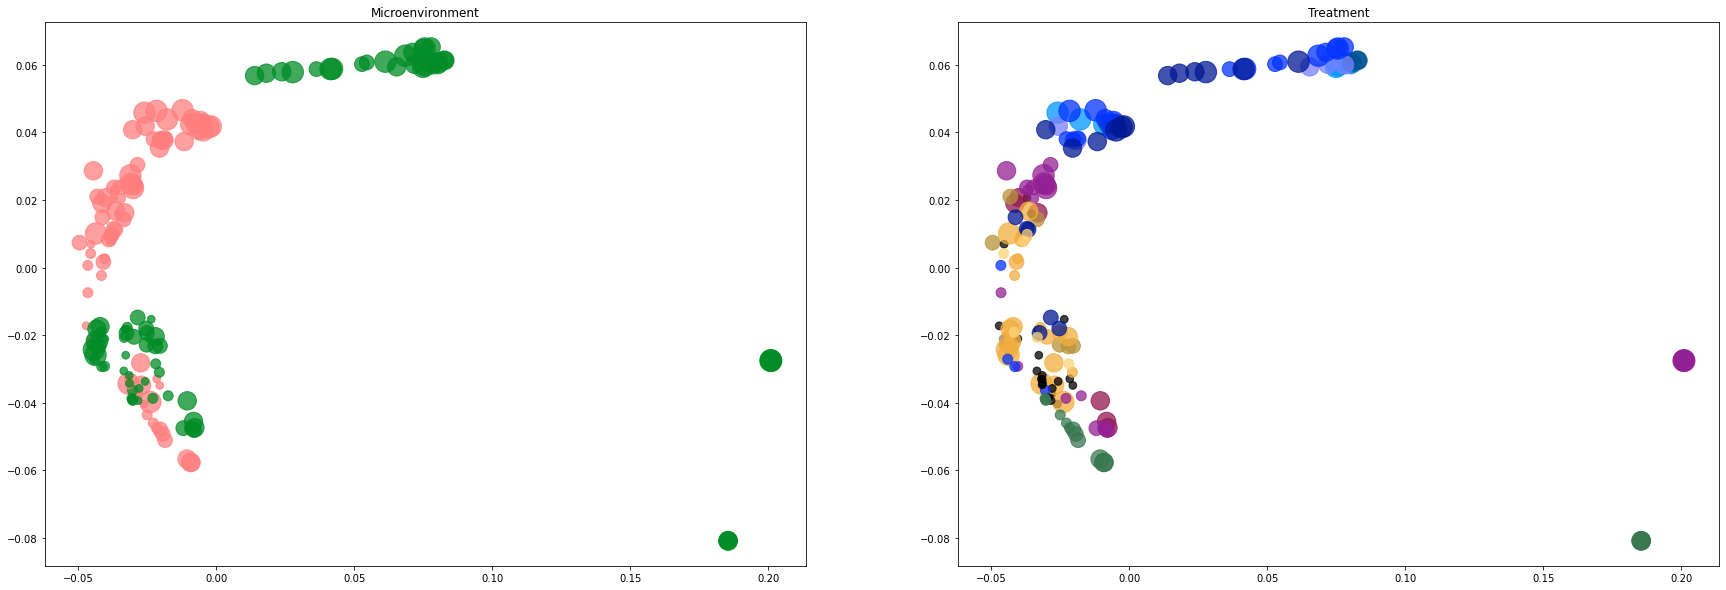

In [21]:
#calculate embedding using the paired Trellis embeddings
phate_op = phate.PHATE(
    random_state=42,
    n_jobs=-2,
    knn_dist="manhattan",
    n_pca=None,
    verbose=False,
)
phate_coords_funct = phate_op.fit_transform(paired_embeds)

#Define palettes and sizes for the plots
patients = {'11':'#da70d6', '21': '#9acd32', '23':'#cd5c5c', '27':'#7d0f0f', '75':'#808000', 
            '99':'#add8e6', '109':'#3b65a8', '141':'#663399', '216':'#8b008b', '5': '#d42f81'}
culture = {'PDO':'#008C26', 'PDOF':'#FF7F7F', 'F':'blue'}
treatment = {'DMSO':'#000000', 'H2O':'#000000', 'AH':'#000000', 'S':'#0433FF', 'VS':'#011993', 'L':'#F2AE40', 'F':'#942193', 
             'C':'#B7933A', 'CS':'#005493', 'CSF':'#0096FF', 'SF':'#7A81FF', 'V':'#FFD479', 'CF':'#941751', 'O':'#38774F'} 
concentration = {0:60, 1:100, 2:220, 3:340, 4:460, 5:540}

#And plot the PHATE embedding!
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

#Colour plot by microenvironment
plt.subplot(1, 2, 1)
plt.title("Microenvironment")
plt.scatter(phate_coords_funct[:,0], phate_coords_funct[:,1], c=meta['Culture'].map(culture),
    s=meta['Concentration'].map(concentration), alpha = .75)

#Colour plot by treatment
plt.subplot(1, 2, 2)
plt.title("Treatment")
plt.scatter(phate_coords_funct[:,0], phate_coords_funct[:,1], c=meta['Treatment'].map(treatment),
    s=meta['Concentration'].map(concentration), alpha = .75)
